In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
# Set seed for replayability
from numpy.random import seed 
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
pd.options.mode.chained_assignment = None  # default='warn'


# <span style='font-family:"Times New Roman"'> <span styel=''>Data pre-processing

In [2]:
# Read data
df = pd.read_csv('NewCases_Data/export_dataframe.csv')
df


,date,newCasesByPublishDate,newDeaths28DaysByPublishDate,newAdmissions,hospitalCases,covidOccupiedMVBeds,London
0,2020-04-21,4301,1224,1713,19139,3036,0.09
1,2020-04-22,4451,847,1527,18533,2964,0.09
2,2020-04-23,4583,682,1513,17867,2867,0.09
3,2020-04-24,5386,1010,1525,17063,2703,0.09
4,2020-04-25,4913,815,1255,16604,2702,0.08
...,...,...,...,...,...,...,...
291,2021-02-06,18262,828,1880,26881,3373,0.21
292,2021-02-07,15845,373,1846,26767,3302,0.21
293,2021-02-08,14104,333,1909,26706,3230,0.24
294,2021-02-09,12364,1052,1743,25643,3164,0.22


In [3]:
df_data = df[['date','newCasesByPublishDate','newDeaths28DaysByPublishDate'
             ,'newAdmissions','hospitalCases','covidOccupiedMVBeds','London']]
df_data


,date,newCasesByPublishDate,newDeaths28DaysByPublishDate,newAdmissions,hospitalCases,covidOccupiedMVBeds,London
0,2020-04-21,4301,1224,1713,19139,3036,0.09
1,2020-04-22,4451,847,1527,18533,2964,0.09
2,2020-04-23,4583,682,1513,17867,2867,0.09
3,2020-04-24,5386,1010,1525,17063,2703,0.09
4,2020-04-25,4913,815,1255,16604,2702,0.08
...,...,...,...,...,...,...,...
291,2021-02-06,18262,828,1880,26881,3373,0.21
292,2021-02-07,15845,373,1846,26767,3302,0.21
293,2021-02-08,14104,333,1909,26706,3230,0.24
294,2021-02-09,12364,1052,1743,25643,3164,0.22


In [4]:
# Separate dates for future plotting
all_dates = pd.to_datetime(df_data['date'])

# Extract features
n_features = 6
cols = list(df_data)[1:n_features + 1]
data = df_data[cols].astype(float)

# Split into the train set and the test set
split = 0.75
x = int(data.shape[0] * split)
train_set, test_set = data[:x], data[x:]
print("train set:", train_set.shape)
print("test set:", test_set.shape)


train set: (222, 6)
test set: (74, 6)


In [5]:
# Number of days predicted into the future
n_future = 5

# Number of past days used as the input
n_past = 4

# Normalize the train set
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
train_data_scaled = scaler.transform(train_set)

print("train set size:", train_data_scaled.shape)
print("train set type:", type(train_data_scaled))


train set size: (222, 6)
train set type: <class 'numpy.ndarray'>


In [6]:
# Reshape input and output
train_X, train_Y = [], []

for i in range(n_past, train_data_scaled.shape[0] - n_future + 1):
    train_X.append(train_data_scaled[i - n_past:i, 0:train_data_scaled.shape[1]])
    train_Y.append(train_data_scaled[i:i + n_future, 0])

train_x, train_y = np.array(train_X), np.array(train_Y)

print("train x:", train_x.shape)
print("train y:", train_y.shape)


train x: (214, 4, 6)
train y: (214, 5)


# <span style='font-family:"Times New Roman"'> <span styel=''>Model training

In [7]:
# CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(train_y.shape[1]))

model.compile(optimizer='adam', loss='mse')

# Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='max')
history = model.fit(train_x, train_y, epochs=100, batch_size=n_past, validation_split=0.1, verbose=1, callbacks=[reduce_lr])


Epoch 1/100
48/48 [==============================] - 0s 5ms/step - loss: 0.2564 - val_loss: 0.2593
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0721 - val_loss: 0.1566
Epoch 3/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0559 - val_loss: 0.1386
Epoch 4/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.1175
Epoch 5/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.1001
Epoch 6/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.1028
Epoch 7/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0952
Epoch 8/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0923
Epoch 9/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0819
Epoch 10/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0740
Epoch 11/

48/48 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0738
Epoch 84/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0738
Epoch 85/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0738
Epoch 86/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.0738
Epoch 87/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0738
Epoch 88/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.0738
Epoch 89/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0252 - val_loss: 0.0738
Epoch 90/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0248 - val_loss: 0.0738
Epoch 91/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.0738
Epoch 92/100
48/48 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.0738
Epoch 93/100


# <span style='font-family:"Times New Roman"'> <span styel=''>Model validation

Text(0.5, 1.0, 'model train vs validation loss')

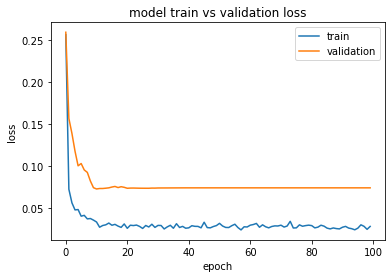

In [8]:
# Plot model train vs validation loss
sns.lineplot(data=history.history['loss'])
sns.lineplot(data=history.history['val_loss'])
plt.legend(labels=['train', 'validation'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("model train vs validation loss")


# <span style='font-family:"Times New Roman"'> <span styel=''>Model testing

In [9]:
# Reshape input and output
test_data_scaled = scaler.transform(test_set)

test_X, test_Y = [], []

for i in range(n_past, test_data_scaled.shape[0] - n_future + 1):
    test_X.append(test_data_scaled[i - n_past:i, 0:test_data_scaled.shape[1]])
    test_Y.append(test_data_scaled[i:i + n_future, 0])

test_x, test_y = np.array(test_X), np.array(test_Y)

print("test x shape:", test_x.shape)
print("test y shape:", test_y.shape)


test x shape: (66, 4, 6)
test y shape: (66, 5)


In [10]:
results = model.evaluate(test_x, test_y)
predict_y = model.predict(test_x)
model_y = model.predict(train_x)


# Inverse transform for multiple output
def inverse_transform(data):
    for i in range(len(data)):
        data_copies = data[i]
        data_copies = np.repeat(data_copies[:, np.newaxis], train_set.shape[1], 1)
        data[i] = scaler.inverse_transform(data_copies)[:, 0]
    return data


predict_y = inverse_transform(predict_y)
test_y = inverse_transform(test_y)
model_y = inverse_transform(model_y)
train_y = inverse_transform(train_y)


# Evaluate per-day predictions
def perDay_rmse(tests, predictions):
    for i in range(n_future):
        actual = [test[i] for test in tests]
        predicted = [prediction[i] for prediction in predictions]
        rmse = mean_squared_error(actual, predicted, squared=False)
        print('Day-%d RMSE is %f' % ((i + 1), rmse))


print("validation:")
perDay_rmse(train_y[int(-0.1 * len(train_x)) - 1:], model_y[int(-0.1 * len(train_x)) - 1:])

print("*"*40)
print("test:")
perDay_rmse(test_y, predict_y)


3/3 [==============================] - 0s 997us/step - loss: 0.8916
validation:
Day-1 RMSE is 3769.585450
Day-2 RMSE is 4312.852182
Day-3 RMSE is 4851.320665
Day-4 RMSE is 4741.217037
Day-5 RMSE is 4735.576288
****************************************
test:
Day-1 RMSE is 13933.805629
Day-2 RMSE is 15130.264134
Day-3 RMSE is 17361.944293
Day-4 RMSE is 15118.086185
Day-5 RMSE is 16431.810291


##### 